In [ ]:
# Python code to implement uniform search and dichotomy methods, test on two functions,
# compute reference minima via golden-section, run experiments, plot results, and present table.
# This will execute and display outputs for the user.
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Counted function wrapper
class CountedFunc:
    def __init__(self, func):
        self.func = func
        self.evals = 0
    def __call__(self, x):
        self.evals += 1
        return self.func(x)
    def reset(self):
        self.evals = 0

# Define the two target functions
def f1(x):
    return (x+1)**2 + 2*x + 1  # simplifies to x^2 + 4x + 2

def f2(x):
    return (x-2)**2 + (2*x-5)**2 + (x+2)**3

# Golden-section search for high-precision reference minimum
def golden_section(f, a, b, tol=1e-9, maxiter=2000):
    gr = (math.sqrt(5) - 1) / 2  # 1/phi
    c = b - gr * (b - a)
    d = a + gr * (b - a)
    fc = f(c); fd = f(d)
    it = 0
    while abs(b - a) > tol and it < maxiter:
        if fc < fd:
            b = d
            d = c
            fd = fc
            c = b - gr * (b - a)
            fc = f(c)
        else:
            a = c
            c = d
            fc = fd
            d = a + gr * (b - a)
            fd = f(d)
        it += 1
    x_min = (a + b) / 2
    return x_min, f(x_min)

# Uniform (exhaustive) search: sample N+1 equally spaced points on [a,b]
def uniform_search(f, a, b, N):
    # N segments -> N+1 points
    x_vals = np.linspace(a, b, N+1)
    f_vals = [f(x) for x in x_vals]
    idx = int(np.argmin(f_vals))
    x_min = x_vals[idx]
    return x_min, f_vals[idx]

# Dichotomy method (using two interior points separated by delta)
def dichotomy(f, a, b, eps=1e-5, delta=None, maxiter=10000):
    if delta is None:
        delta = eps / 4.0
    fa_evals = 0
    it = 0
    while (b - a) / 2.0 > eps and it < maxiter:
        mid = (a + b) / 2.0
        x1 = mid - delta
        x2 = mid + delta
        f1v = f(x1)
        f2v = f(x2)
        if f1v <= f2v:
            b = x2
        else:
            a = x1
        it += 1
    x_min = (a + b) / 2.0
    return x_min, f(x_min), it

# Setup problems
interval = (-6.0, 6.0)
# Compute high-precision reference minima (using counted wrapper but we won't count these evals towards method counts)
ref_f1 = CountedFunc(f1)
ref_x1, ref_val1 = golden_section(ref_f1, interval[0], interval[1], tol=1e-10)
ref_f1.reset()

ref_f2 = CountedFunc(f2)
ref_x2, ref_val2 = golden_section(ref_f2, interval[0], interval[1], tol=1e-10)
ref_f2.reset()

ref_x1, ref_val1, ref_x2, ref_val2



(-1.9999999833569806, -2.0, 0.5099880373809368, 33.87375099820431)

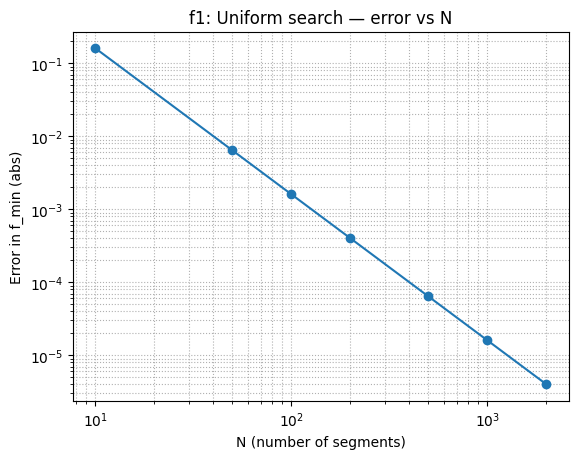

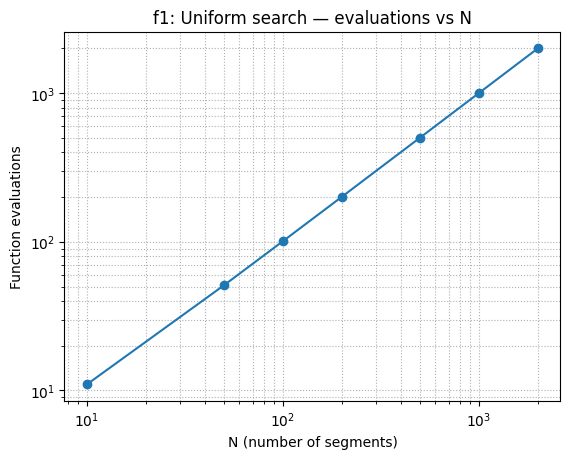

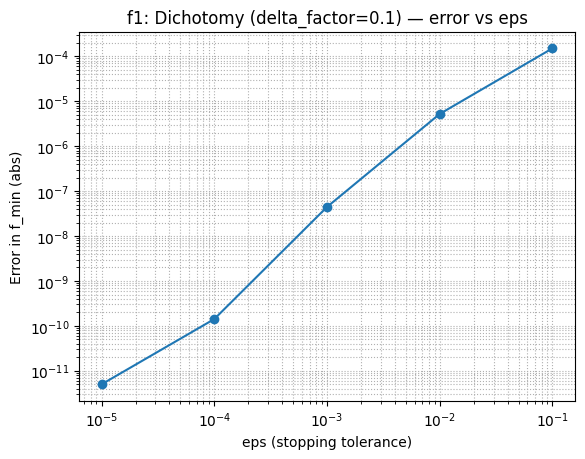

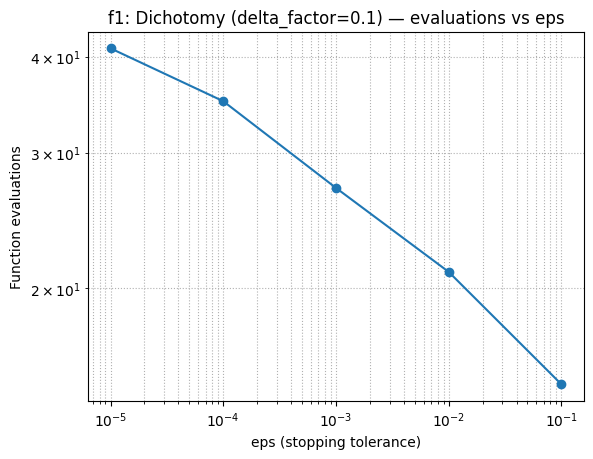

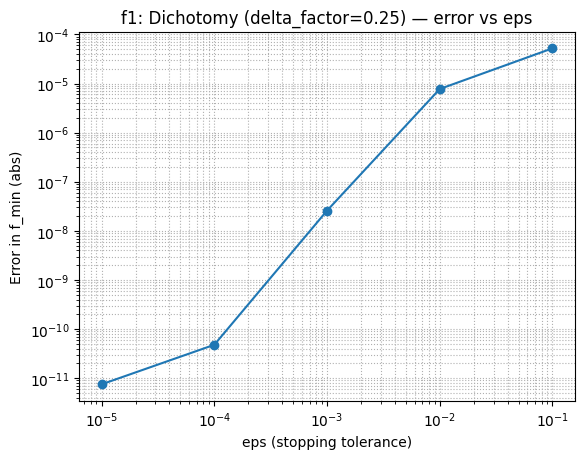

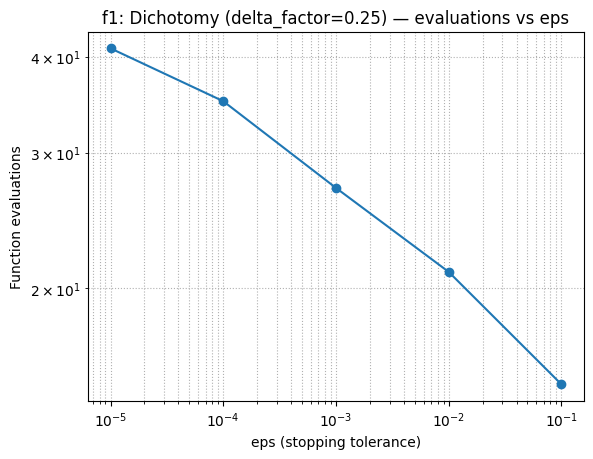

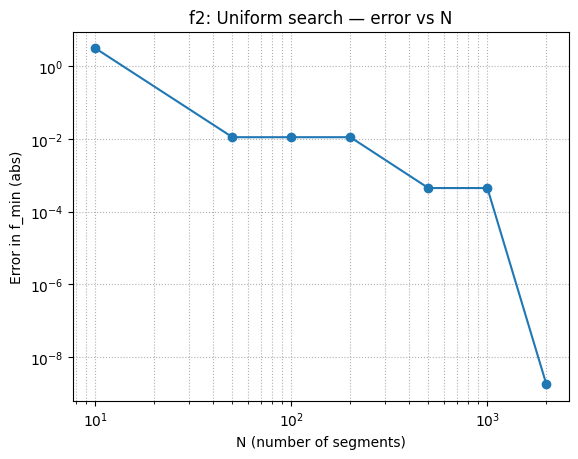

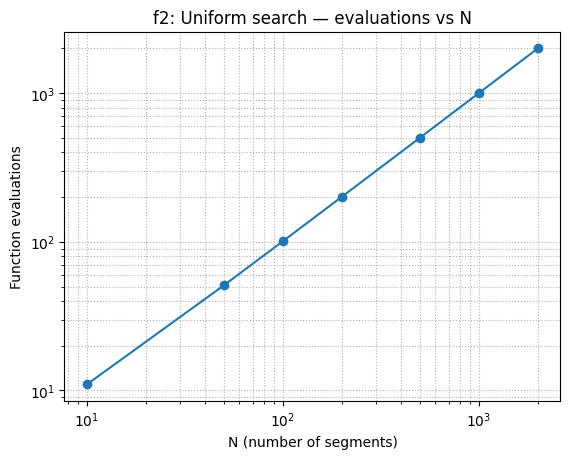

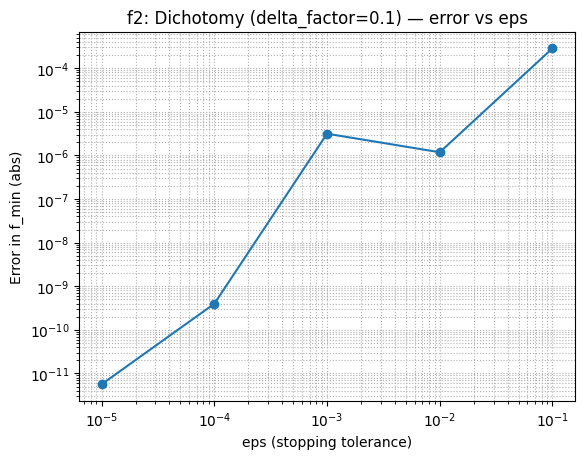

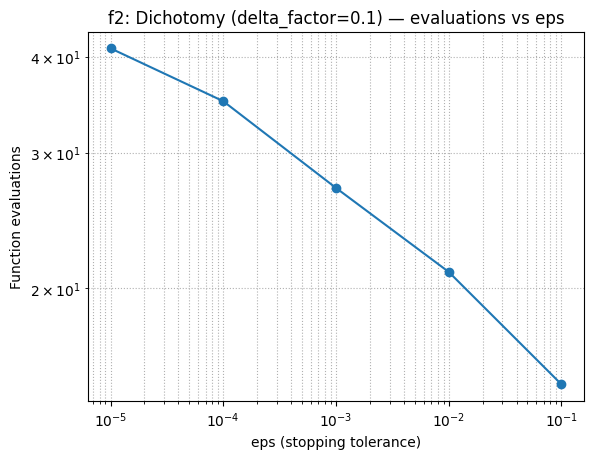

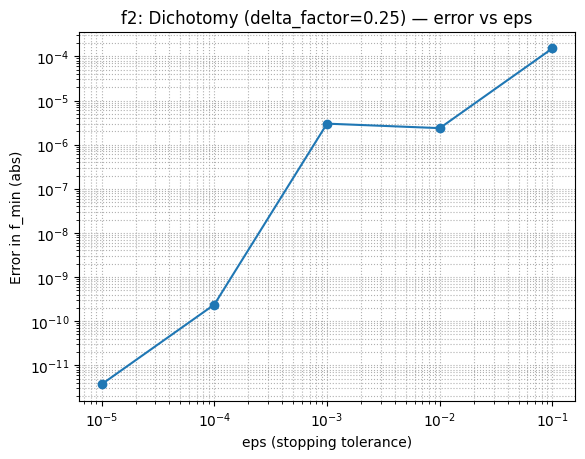

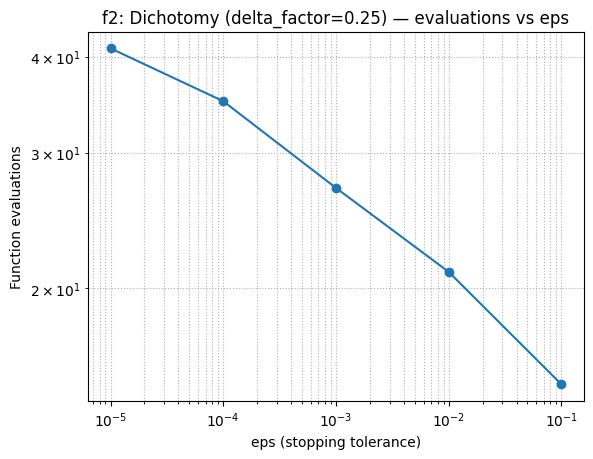

In [ ]:
# Run experiments and produce plots & summary table

# Experiment parameters
Ns = [10, 50, 100, 200, 500, 1000, 2000]
epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
delta_factors = [0.25, 0.1]  # delta = factor * eps

results = []


# Helper to run methods counting function calls
def run_uniform(func, a, b, N, ref_val):
    cf = CountedFunc(func)
    x_min, f_min = uniform_search(cf, a, b, N)
    evals = cf.evals
    err = abs(f_min - ref_val)
    return {
        "method": "uniform",
        "param": N,
        "evals": evals,
        "f_min": f_min,
        "error": err,
        "x_min": x_min,
    }


def run_dichotomy(func, a, b, eps, delta_factor, ref_val):
    cf = CountedFunc(func)
    delta = delta_factor * eps
    x_min, f_min, iters = dichotomy(cf, a, b, eps=eps, delta=delta)
    evals = cf.evals
    err = abs(f_min - ref_val)
    return {
        "method": "dichotomy",
        "eps": eps,
        "delta_factor": delta_factor,
        "evals": evals,
        "f_min": f_min,
        "error": err,
        "x_min": x_min,
        "iters": iters,
    }


# Run for both functions
for N in Ns:
    r1 = run_uniform(f1, interval[0], interval[1], N, ref_val1)
    r1.update({"function": "f1"})
    results.append(r1)
    r2 = run_uniform(f2, interval[0], interval[1], N, ref_val2)
    r2.update({"function": "f2"})
    results.append(r2)

for eps in epsilons:
    for df in delta_factors:
        r1 = run_dichotomy(f1, interval[0], interval[1], eps, df, ref_val1)
        r1.update({"function": "f1"})
        results.append(r1)
        r2 = run_dichotomy(f2, interval[0], interval[1], eps, df, ref_val2)
        r2.update({"function": "f2"})
        results.append(r2)

df = pd.DataFrame(results)
# Reorder columns for readability
cols = [
    "function",
    "method",
    "param",
    "eps",
    "delta_factor",
    "iters",
    "evals",
    "x_min",
    "f_min",
    "error",
]
for c in cols:
    if c not in df.columns:
        df[c] = np.nan
df = df[cols]


# Plotting: for each function and method, show error vs parameter and evals vs parameter
def plot_for_function(fname):
    sub = df[df["function"] == fname]
    # Uniform plots
    uni = sub[sub["method"] == "uniform"].copy()
    # dichotomy plots: multiple delta_factors -> plot separate markers
    dich = sub[sub["method"] == "dichotomy"].copy()

    plt.figure()
    plt.loglog(uni["param"], uni["error"], marker="o")
    plt.xlabel("N (number of segments)")
    plt.ylabel("Error in f_min (abs)")
    plt.title(f"{fname}: Uniform search — error vs N")
    plt.grid(True, which="both", ls=":")
    plt.show()

    plt.figure()
    plt.loglog(uni["param"], uni["evals"], marker="o")
    plt.xlabel("N (number of segments)")
    plt.ylabel("Function evaluations")
    plt.title(f"{fname}: Uniform search — evaluations vs N")
    plt.grid(True, which="both", ls=":")
    plt.show()

    # Dichotomy: group by delta_factor
    for dfact in sorted(dich["delta_factor"].unique()):
        part = dich[dich["delta_factor"] == dfact]
        plt.figure()
        plt.loglog(part["eps"], part["error"], marker="o")
        plt.xlabel("eps (stopping tolerance)")
        plt.ylabel("Error in f_min (abs)")
        plt.title(f"{fname}: Dichotomy (delta_factor={dfact}) — error vs eps")
        plt.grid(True, which="both", ls=":")
        plt.show()

        plt.figure()
        plt.loglog(part["eps"], part["evals"], marker="o")
        plt.xlabel("eps (stopping tolerance)")
        plt.ylabel("Function evaluations")
        plt.title(f"{fname}: Dichotomy (delta_factor={dfact}) — evaluations vs eps")
        plt.grid(True, which="both", ls=":")
        plt.show()


# Plot for both functions
plot_for_function("f1")
plot_for_function("f2")

# Print a compact summary table (pivot)
pivot = df.pivot_table(
    index=["function", "method"],
    values=["evals", "error"],
    aggfunc=["min", "max", "mean"],
).round(6)

# Also show reference minima
ref_table = pd.DataFrame(
    [
        {"function": "f1", "ref_x": ref_x1, "ref_f": ref_val1},
        {"function": "f2", "ref_x": ref_x2, "ref_f": ref_val2},
    ]
)
